# INTRODUCTION

**Purpose:** Tutorial on how to work with the mesh2voxel functionality.

**Speed-up initiatives**: TODO: Come up with a better name for this. 

Several initiatives have been implemented to optimize the computation speed:
- Parallelization at Tensor-level.
- GPU-compatibility: Thanks to `pytorch` and `pytorch3d` this is easy.
- z-slab-batching: Iterate through the points in slabs along the z-direction. Should have a positive effect for any mesh.
- Inter-slab-cropping. For each slab, only consider the points that are within the bounding box of the mesh for the given z-interval. Has an effect when the structure is elongated and with variation in the xy-plane.

**Resources:** A few resources are provided for testing.

Two meshes:
- straight_cylinder.ply: 
    - A straight cylinder. 
    - The inter-slab-speed-up initiatives won't have any noticable effect, as the point grid is already cropped closely around the mesh.
    - At z=100 and z=200 the edges align to make a circle. At this exact position along z, the need for multiple ray_directions is therefore seen clearly.
- curved_cylinder.ply: 
    - A curved cylinder.
    - The inter-slab-speed-up initiatives have a noticable effect, as cropping the point grid per slab has a large effect.
    
**Quick overview of the method:**
- Goal: To obtain a segmentation of a mesh in voxel-space.
- Method:
    - A voxel is classified as being inside the mesh only if all eight corners of that voxel are inside the mesh.
    - A grid representing all corners of all voxels are generated with the resolution `res`. Each corner is represented as a point in 3d.
    - A point is classified as being inside or outside the mesh by checking the number of intersections between a ray scattered from that point, and the mesh. 
        - If a ray intersects an even number of times, we know that the origin is outside the mesh.
        - If a ray intersects an uneven number of times, we know that the origin is inside the mesh.
    - Due to numerical errors and such, multiple rays are scattered from each point, and the final classification is based on a majority vote.

# THE BASICS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Make GPU visible. Must be done before torch is imported.
# Might not work for all cluster set-ups.
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1" #index of gpu of interest

In [13]:
import sys
import numpy as np
import pymesh
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import pytorch3d as torch3d
from pytorch3d import io

sys.path.append('../src/')
import mesh_io as mesh_io
import close_roundish_holes as crh
import mesh_to_voxels as m2v
import plotting as pm

In [14]:
torch.set_default_dtype(torch.float64)

# DEVICE

Check available devices. Choose GPU if one is available. Else choose cpu.

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

print(f'number of devices: {torch.cuda.device_count()}')
print(f'device: {device}')

number of devices: 1
device: cuda:0


# PATHS

In [16]:
# mesh
path_meshes = '../resources/meshes/'
# name_mesh = 'straight_cylinder'
name_mesh = 'curved_cylinder'
path_mesh = os.path.join(path_meshes, name_mesh+'.ply')

# others
path_figures = '../figures/'

# CLOSE HOLES

This functionality is currently based on pymesh. Will be converted to pytorch3d.

Skip this if you know your mesh is completely closed/water tight and you have issues with pymesh.

A mesh cannot be segmented unless it is completely closed/water tight.

In [17]:
mesh = mesh_io.load_mesh(path_mesh)

In [18]:
mesh = crh.close_holes(mesh)    

Closing 2 holes.


In [19]:
#### save closed meshes
if '_closed' not in path_mesh:

    path_mesh = path_mesh.replace('.ply', '_closed.ply')
    
    pymesh.save_mesh(path_mesh, mesh, ascii=True)

# PLOT MESH: FOR VISUAL INSPECTION

Skip this if you didn't install `plotly`.

In [20]:
pm.create_figure_for_inspection(mesh, path_figures+name_mesh+'.html')

Figure was saved to ../figures/curved_cylinder.html. Check it out in your browser (Firefox might work better).


# MESH TO VOXELS

In [21]:
# TODO: Add estimation of memory consumption! And make the user confirm.

In [22]:
# inspection mode
mask_voxel_corners_inside, intersections = m2v.check_if_voxel_corners_are_inside_mesh(path_mesh, res=0.1, device=device, inspection_mode=True)

# regular mode
# mask_inside = m2v.mesh2voxels(path_mesh, res=0.1, device=device, inspection_mode=False)

# convert from point-space to voxel-space
segmentation = m2v.get_segmentation_from_mask_voxel_corners_inside(mask_voxel_corners_inside)

The points to be segmented are organized in a grid of shape torch.Size([106, 80, 1531]). That is 12982880 points in total.
n_z_slices_per_batch:  6


	 Checking 154/8576 faces.
	 Ignoring 0.89 ray_origins in this slab.
	 Checking 192/8576 faces.
	 Ignoring 0.88 ray_origins in this slab.
	 Checking 196/8576 faces.
	 Ignoring 0.88 ray_origins in this slab.
	 Checking 222/8576 faces.
	 Ignoring 0.87 ray_origins in this slab.
	 Checking 196/8576 faces.
	 Ignoring 0.87 ray_origins in this slab.
	 Checking 207/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 223/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 193/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 232/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 227/8576 faces.
	 Ignoring 0.84 ray_origins in this slab.
	 Checking 208/8576 faces.
	 Ignoring 0.84 ray_origins in this slab.
	 Checking 235/8576 faces.
	 Ignoring 0.84 ray_origins in this slab.
	 Checking 198/8576 faces.
	 Ignoring 0.85 ray_origins in this slab.
	 Checking 211/8576 faces.
	 Ignoring 0.85 ray_origins in this slab.
	 Checking 217/8576 faces.
	 Ignor

	 Checking 198/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 195/8576 faces.
	 Ignoring 0.87 ray_origins in this slab.
	 Checking 191/8576 faces.
	 Ignoring 0.87 ray_origins in this slab.
	 Checking 198/8576 faces.
	 Ignoring 0.87 ray_origins in this slab.
	 Checking 200/8576 faces.
	 Ignoring 0.88 ray_origins in this slab.
	 Checking 210/8576 faces.
	 Ignoring 0.88 ray_origins in this slab.
	 Checking 183/8576 faces.
	 Ignoring 0.88 ray_origins in this slab.
	 Checking 162/8576 faces.
	 Ignoring 0.88 ray_origins in this slab.
	 Checking 157/8576 faces.
	 Ignoring 0.88 ray_origins in this slab.
	 Checking 182/8576 faces.
	 Ignoring 0.88 ray_origins in this slab.
	 Checking 185/8576 faces.
	 Ignoring 0.87 ray_origins in this slab.
	 Checking 192/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 177/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 168/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 172/8576 faces.
	 Ignor

	 Checking 193/8576 faces.
	 Ignoring 0.84 ray_origins in this slab.
	 Checking 201/8576 faces.
	 Ignoring 0.85 ray_origins in this slab.
	 Checking 178/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 203/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 190/8576 faces.
	 Ignoring 0.87 ray_origins in this slab.
	 Checking 162/8576 faces.
	 Ignoring 0.87 ray_origins in this slab.
	 Checking 195/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 196/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 172/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 189/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 175/8576 faces.
	 Ignoring 0.87 ray_origins in this slab.
	 Checking 179/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 184/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 177/8576 faces.
	 Ignoring 0.86 ray_origins in this slab.
	 Checking 209/8576 faces.
	 Ignor

# CHECK RESULTING SEGMENTATION

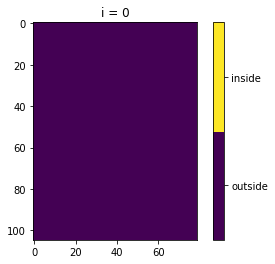

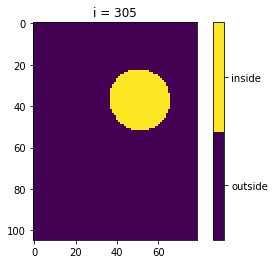

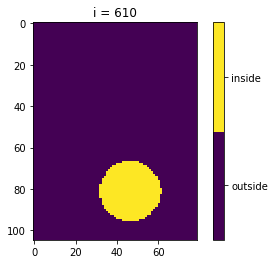

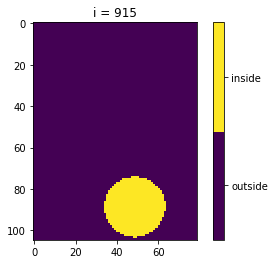

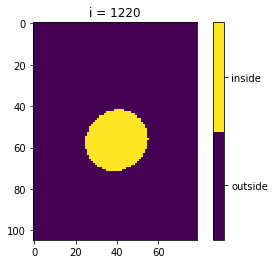

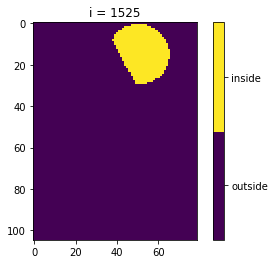

In [23]:
cmap = plt.cm.get_cmap('viridis', 2)

for idx_slice in range(0, segmentation.shape[-1],(segmentation.shape[-1]-1)//5):
# for idx_slice in [0, 1000, 2000, 3000]:
    
    plt.imshow(segmentation[:, :, idx_slice].to('cpu')*1, vmin=0, vmax=1, cmap=cmap)
    plt.title(f'i = {idx_slice}')
    cbar = plt.colorbar()
    cbar.set_ticks([0.25, 0.75])
    cbar.set_ticklabels(['outside', 'inside'])
    plt.show()

# INSPECT PRELIMINARY RESULTS

### FOR INDIVIDUAL RAY-DIRECTIONS, SEGMENTATION (PER POINT), AND SEGMENTATION (PER VOXEL)

- **Individual ray-directions:** Shows whether or not each point was classified as being inside or outside of the mesh for each of the ray_diretions.
- **Segmentation (per point):** Shows how the result for the individual ray_directions were accumulated.
- **Segmentation (per voxel):** Shows whether or not each voxel was classified as being inside or outside of the mesh. A voxel is only classified as being inside the mesh if all of it's eight corners are inside the mesh. 

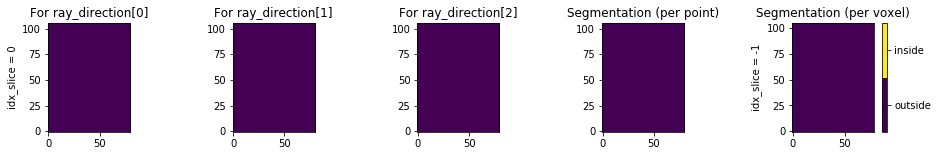

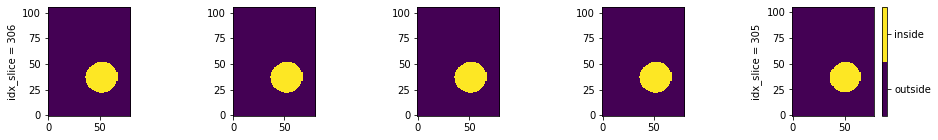

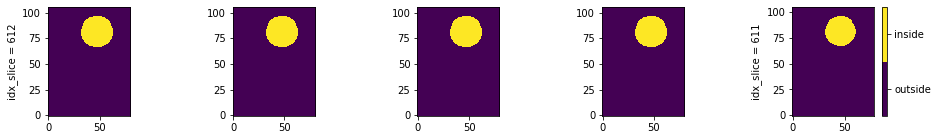

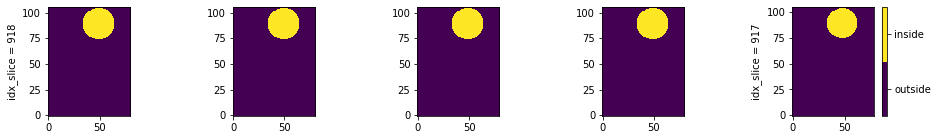

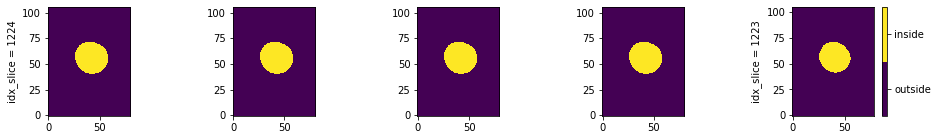

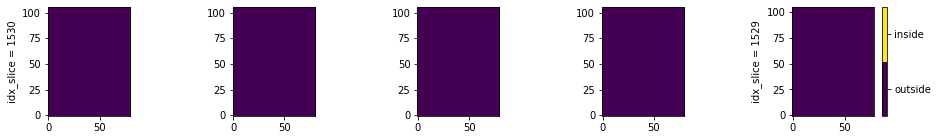

In [24]:
cmap = plt.cm.get_cmap('viridis', 2)

_0 = (intersections[0] % 2 == 1) * 1
_1 = (intersections[1] % 2 == 1) * 1
_2 = (intersections[2] % 2 == 1) * 1
_3 = mask_voxel_corners_inside

cmax = max([torch.max(_0), torch.max(_1), torch.max(_2), torch.max(_3)])

# for i, idx_slice in enumerate([1, 1000, 2000, 2999, 3000, 3001]):
for i, idx_slice in enumerate(range(0, mask_voxel_corners_inside.shape[-1], mask_voxel_corners_inside.shape[-1]//5)):
    
    fig, axs = plt.subplots(1, 5, figsize=(16, 2))
    
    im0 = axs[0].imshow(_0[:, :, idx_slice].to('cpu'), vmin=0, vmax=cmax, cmap=cmap, origin='lower')
    im1 = axs[1].imshow(_1[:, :, idx_slice].to('cpu'), vmin=0, vmax=cmax, cmap=cmap, origin='lower')
    im2 = axs[2].imshow(_2[:, :, idx_slice].to('cpu'), vmin=0, vmax=cmax, cmap=cmap, origin='lower')
    im3 = axs[3].imshow(_3[:, :, idx_slice].to('cpu'), vmin=0, vmax=cmax, cmap=cmap, origin='lower')
    im4 = axs[4].imshow(segmentation[:, :, idx_slice-1].to('cpu'), vmin=0, vmax=cmax, cmap=cmap, origin='lower')
    
    cbar4 = fig.colorbar(im4, ax=axs[4])
    
    cbar4.set_ticks([0.25, 0.75])
    cbar4.set_ticklabels(['outside', 'inside'])
    
    axs[0].set_ylabel(f'idx_slice = {idx_slice}')
    axs[4].set_ylabel(f'idx_slice = {idx_slice-1}')
    
    if i == 0:
        
        axs[0].set_title('For ray_direction[0]')
        axs[1].set_title('For ray_direction[1]')
        axs[2].set_title('For ray_direction[2]')
        axs[3].set_title('Segmentation (per point)')
        axs[4].set_title('Segmentation (per voxel)')
    
    plt.show()

### FOR INDIVIDUAL RAY-DIRECTIONS, SEGMENTATION (PER POINT), AND SEGMENTATION (PER VOXEL)

- **Individual ray-directions:** Shows how many intersections were registered for each point for each of the ray_diretions.
- **Segmentation (per point):** Shows how the result for the individual ray_directions were accumulated.
- **Segmentation (per voxel):** Shows whether or not each voxel was classified as being inside or outside of the mesh. A voxel is only classified as being inside the mesh if all of it's eight corners are inside the mesh. 

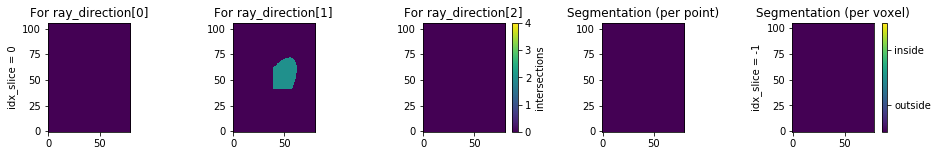

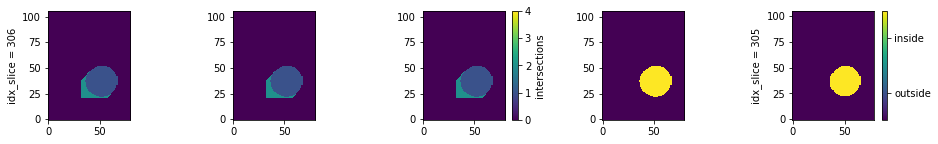

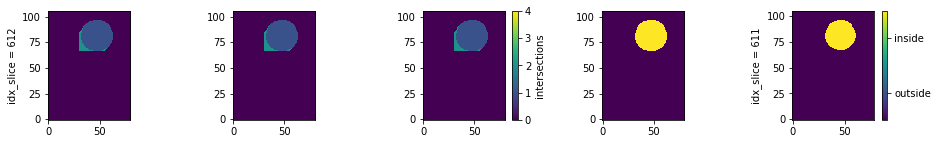

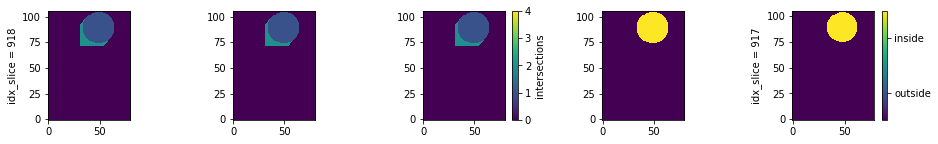

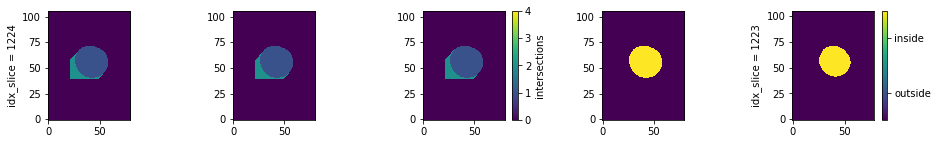

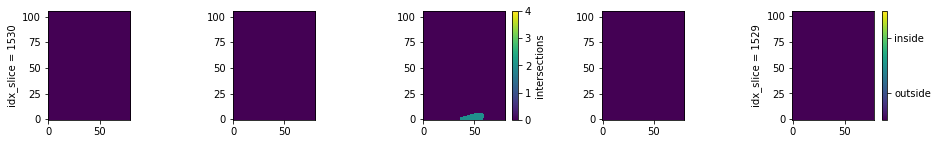

In [25]:
cmap = plt.cm.get_cmap('viridis')

_0 = intersections[0]
_1 = intersections[1]
_2 = intersections[2]
_3 = mask_voxel_corners_inside

cmax = max([torch.max(_0), torch.max(_1), torch.max(_2), torch.max(_3)])

# for i, idx_slice in enumerate([1, 1000, 2000, 2999, 3000, 3001]):
for i, idx_slice in enumerate(range(0, mask_voxel_corners_inside.shape[-1], mask_voxel_corners_inside.shape[-1]//5)):
    
    fig, axs = plt.subplots(1, 5, figsize=(16, 2))
    
    im0 = axs[0].imshow(_0[:, :, idx_slice].to('cpu'), vmin=0, vmax=cmax, cmap=cmap, origin='lower')
    im1 = axs[1].imshow(_1[:, :, idx_slice].to('cpu'), vmin=0, vmax=cmax, cmap=cmap, origin='lower')
    im2 = axs[2].imshow(_2[:, :, idx_slice].to('cpu'), vmin=0, vmax=cmax, cmap=cmap, origin='lower')
    im3 = axs[3].imshow(_3[:, :, idx_slice].to('cpu'), vmin=0, vmax=1, cmap=cmap, origin='lower')
    im4 = axs[4].imshow(segmentation[:, :, idx_slice-1].to('cpu'), vmin=0, vmax=1, cmap=cmap, origin='lower')
    
    cbar2 = fig.colorbar(im2, ax=axs[2])
    cbar2.set_label('intersections')
    
    cbar4 = fig.colorbar(im4, ax=axs[4])
    cbar4.set_ticks([0.25, 0.75])
    cbar4.set_ticklabels(['outside', 'inside'])
    
    axs[0].set_ylabel(f'idx_slice = {idx_slice}')
    axs[4].set_ylabel(f'idx_slice = {idx_slice-1}')
    
    if i == 0:
        
        axs[0].set_title('For ray_direction[0]')
        axs[1].set_title('For ray_direction[1]')
        axs[2].set_title('For ray_direction[2]')
        axs[3].set_title('Segmentation (per point)')
        axs[4].set_title('Segmentation (per voxel)')
    
    plt.show()

# INSPECT MEMORY CONSUMPTION

For debugging. TODO: Remove.

In [26]:
import torch
import gc
import sys

def check_memory_consumption():
    counter = 0

    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                counter += 1
                print(counter, type(obj), obj.size(), obj.element_size() * obj.nelement())
                
                for referrer in gc.get_referrers(obj):
                    if isinstance(referrer, dict):
                        for k, v in referrer.items():
                            if v is obj:
                                print('k: ', k)
        except:
            pass
        
check_memory_consumption()

/home/siwin/.conda/envs/mesh_utils/lib/python3.6/site-packages/torch/distributed/distributed_c10d.py:126: UserWarning:

torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead



1 <class 'torch.Tensor'> torch.Size([1, 3, 3]) 36
k:  _R
2 <class 'torch.Tensor'> torch.Size([1, 3]) 12
k:  _T
3 <class 'torch.Tensor'> torch.Size([106, 80, 1531]) 12982880
k:  mask_voxel_corners_inside
k:  _3
4 <class 'torch.Tensor'> torch.Size([106, 80, 1531]) 103863040
k:  _0
5 <class 'torch.Tensor'> torch.Size([106, 80, 1531]) 103863040
k:  _1
6 <class 'torch.Tensor'> torch.Size([106, 80, 1531]) 103863040
k:  _2
7 <class 'torch.Tensor'> torch.Size([105, 79, 1530]) 12691350
k:  segmentation
8 <class 'torch.Tensor'> torch.Size([]) 8
k:  cmax
